# Libraries

In [88]:
# Import 3rd party libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

In [89]:
# Import Sklearn libraries

import datetime 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import KFold


# Pipelines

### Pipeline 1 

In [90]:
def select_columns(df, columns):
    return df.loc[:, columns]

# Importing CSV

In [4]:
df_hour = pd.read_csv("ride_hourly.csv",
                       parse_dates = ["Start_Time"])
df_hour

,Start_Time,Duration,Year,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Spd (km/h),numeric_weather,weekend,type_Clear,type_Moist,type_Rain,type_Snow
0,2017-01-01 00:00:00-05:00,18,2017,1,1,0,1.5,-3.6,69.0,39.0,0,1,1,0,0,0
1,2017-01-01 01:00:00-05:00,13,2017,1,1,1,1.5,-3.9,67.0,35.0,0,1,1,0,0,0
2,2017-01-01 02:00:00-05:00,15,2017,1,1,2,1.0,-4.3,68.0,32.0,0,1,1,0,0,0
3,2017-01-01 03:00:00-05:00,10,2017,1,1,3,1.2,-4.3,67.0,37.0,0,1,1,0,0,0
4,2017-01-01 04:00:00-05:00,5,2017,1,1,4,1.3,-4.4,66.0,28.0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43339,2021-12-11 19:00:00-05:00,581,2021,12,11,19,5.3,-1.3,62.0,45.0,0,1,1,0,0,0
43340,2021-12-11 20:00:00-05:00,286,2021,12,11,20,4.6,-0.9,67.0,54.0,0,1,1,0,0,0
43341,2021-12-11 21:00:00-05:00,284,2021,12,11,21,3.3,-0.5,76.0,41.0,0,1,1,0,0,0
43342,2021-12-11 22:00:00-05:00,277,2021,12,11,22,4.3,-3.3,58.0,35.0,0,1,1,0,0,0


#### Let's see the corelation of weather parameters with each other

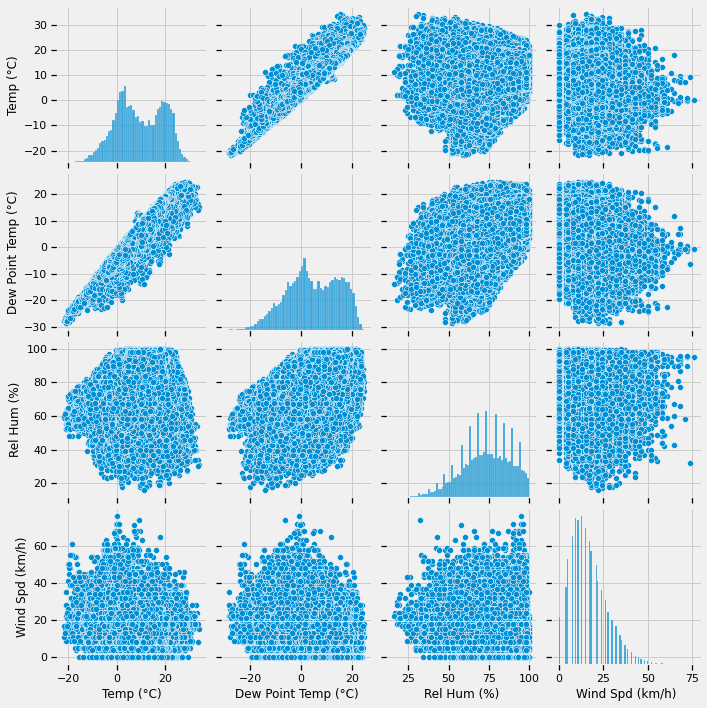

In [6]:
sns.pairplot(df_hour.iloc[:,6:10]);

#### we can see that Temp and Dev temp have a good corelation to each other, so we can use only one of them.

In [7]:
df_hour.drop("Dew Point Temp (°C)", axis = 1, inplace = True)

In [8]:
df_hour.drop("Start_Time", axis = 1, inplace = True)

In [9]:
df_hour

,Duration,Year,Month,Day,Time,Temp (°C),Rel Hum (%),Wind Spd (km/h),numeric_weather,weekend,type_Clear,type_Moist,type_Rain,type_Snow
0,18,2017,1,1,0,1.5,69.0,39.0,0,1,1,0,0,0
1,13,2017,1,1,1,1.5,67.0,35.0,0,1,1,0,0,0
2,15,2017,1,1,2,1.0,68.0,32.0,0,1,1,0,0,0
3,10,2017,1,1,3,1.2,67.0,37.0,0,1,1,0,0,0
4,5,2017,1,1,4,1.3,66.0,28.0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43339,581,2021,12,11,19,5.3,62.0,45.0,0,1,1,0,0,0
43340,286,2021,12,11,20,4.6,67.0,54.0,0,1,1,0,0,0
43341,284,2021,12,11,21,3.3,76.0,41.0,0,1,1,0,0,0
43342,277,2021,12,11,22,4.3,58.0,35.0,0,1,1,0,0,0


##### we have a dataframe of 43344 records of hourly bikerides numbers. Our goal is to predict the number of rides in the future. So, instead of randomly splitting dataframe into train and test, we will split the datframe acording to time inot two parts:
- 95 percent of records will be used to train 
- 5 percent of records will be used to test, 

In [10]:
df_hour_train = df_hour.iloc[:41271,]
df_hour_test = df_hour.iloc[41271:,]

print(df_hour_train.shape[0])
print(df_hour_test.shape[0])

41271
2073


In [15]:
df_X_train = df_hour_train.drop("Duration", axis = 1)
df_y_train = df_hour_train.iloc[:, 0:1]

df_X_test = df_hour_test.drop("Duration", axis = 1)
df_y_test = df_hour_test.iloc[:, 0:1]


#### Let's start with a simple Linear Regression

In [93]:
col = ['Year', 'Month', 'Day', 'Time']

X_train = select_columns(df_X_train, col)
X_test = select_columns(df_X_test, col)

model_smlr1 = LinearRegression()
model_smlr1.fit(X_train, df_y_train)
y_prd = model_smlr1.predict(X_test)
r2_score(df_y_test , model_smlr1.predict(X_test))

0.14525546505782239

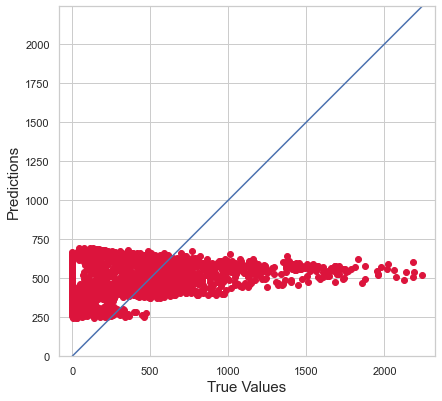

In [146]:
true_value = df_y_test
predicted_value = pd.DataFrame(model_smlr1.predict(X_test),columns =["predicted"], index = df_y_test.index )
plt.figure(figsize=(6,6))
plt.scatter(true_value, predicted_value, c='crimson')


p1 = max(max(predicted_value.iloc[:,0]), max(true_value.iloc[:,0]))
# p2 = min(min(predicted_value.iloc[:,0]), min(true_value.iloc[:,0]))
plt.plot([p1, 0], [p1, 0], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
sns.set_theme(style = "whitegrid")
plt.axis('equal')
plt.xlim([0, p1])
plt.ylim([0, p1])

plt.show();

#### Let's add some features to the model

In [148]:
col = ['Year', 'Month', 'Day', 'Time', 'Temp (°C)',
       'Rel Hum (%)', 'Wind Spd (km/h)', 'numeric_weather', 'weekend']

X_train = select_columns(df_X_train, col)
X_test = select_columns(df_X_test, col)

model_smlr2 = LinearRegression()
model_smlr2.fit(X_train, df_y_train)
y_prd = model_smlr2.predict(X_test)
r2_score(df_y_test , model_smlr2.predict(X_test))

0.249979929690761

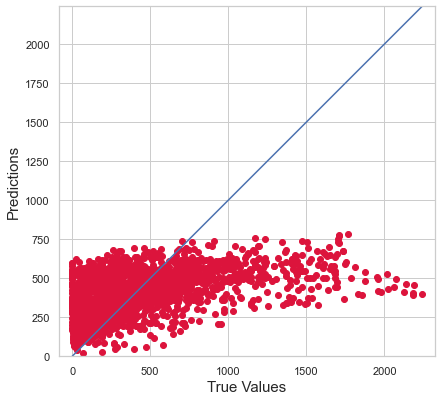

In [149]:
true_value = df_y_test
predicted_value = pd.DataFrame(model_smlr2.predict(X_test),columns =["predicted"], index = df_y_test.index )
plt.figure(figsize=(6,6))
plt.scatter(true_value, predicted_value, c='crimson')


p1 = max(max(predicted_value.iloc[:,0]), max(true_value.iloc[:,0]))
# p2 = min(min(predicted_value.iloc[:,0]), min(true_value.iloc[:,0]))
plt.plot([p1, 0], [p1, 0], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
sns.set_theme(style = "whitegrid")
plt.axis('equal')
plt.xlim([0, p1])
plt.ylim([0, p1])

plt.show();

#### Much better, but still is nothing

In [150]:
col = ['Year', 'Month', 'Day', 'Time', 'Temp (°C)',
       'Rel Hum (%)', 'Wind Spd (km/h)', 'numeric_weather', 'weekend',
       'type_Clear', 'type_Moist', 'type_Rain', 'type_Snow']

X_train = select_columns(df_X_train, col)
X_test = select_columns(df_X_test, col)

model_smlr3 = LinearRegression()
model_smlr3.fit(X_train, df_y_train)
y_prd = model_smlr3.predict(X_test)
r2_score(df_y_test , model_smlr3.predict(X_test))

0.25564205218423064

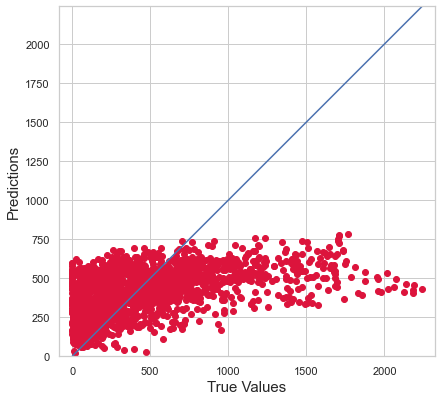

In [151]:
true_value = df_y_test
predicted_value = pd.DataFrame(model_smlr3.predict(X_test),columns =["predicted"], index = df_y_test.index )
plt.figure(figsize=(6,6))
plt.scatter(true_value, predicted_value, c='crimson')


p1 = max(max(predicted_value.iloc[:,0]), max(true_value.iloc[:,0]))
# p2 = min(min(predicted_value.iloc[:,0]), min(true_value.iloc[:,0]))
plt.plot([p1, 0], [p1, 0], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
sns.set_theme(style = "whitegrid")
plt.axis('equal')
plt.xlim([0, p1])
plt.ylim([0, p1])

plt.show();

### Let's try PCA

In [34]:
# initiate PCA 
pca = PCA()

# transform / fit
pca_X_train = pca.fit_transform(df_X_train)
pca_X_test  = pca.transform(df_X_test)
pca_X_train = pd.DataFrame(pca_X_train, columns=["pc{}".format(i+1) for i in range(df_X_train.shape[1])])
pca_X_test  = pd.DataFrame(pca_X_test, columns=["pc{}".format(i+1) for i in range(df_X_train.shape[1])])

#### so we can use the five first pca and have more than 95 percent of variance

In [31]:
pca_summary = pd.DataFrame(columns=["pc{}".format(i+1) for i in range(df_X_train.shape[1])])
pca_summary.loc['var'] = pca.explained_variance_ratio_.cumsum().tolist()
pca_summary

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13
var,0.417406,0.632416,0.771158,0.899966,0.978384,0.995865,0.99904,0.999476,0.999835,0.999934,1.0,1.0,1.0


In [152]:
model_smlr4 = LinearRegression()
model_smlr4.fit(pca_X_train.iloc[:, 0:8], df_y_train)
y_prd = model_smlr4.predict(pca_X_test.iloc[:, 0:8])
r2_score(df_y_test , model_smlr4.predict(pca_X_test.iloc[:, 0:8]))

0.25044029345090535

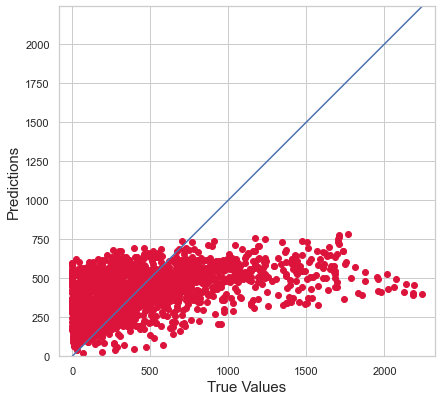

In [154]:
true_value = df_y_test
predicted_value = pd.DataFrame(model_smlr4.predict(pca_X_test.iloc[:, 0:8]),columns =["predicted"], index = df_y_test.index )
plt.figure(figsize=(6,6))
plt.scatter(true_value, predicted_value, c='crimson')


p1 = max(max(predicted_value.iloc[:,0]), max(true_value.iloc[:,0]))
# p2 = min(min(predicted_value.iloc[:,0]), min(true_value.iloc[:,0]))
plt.plot([p1, 0], [p1, 0], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
sns.set_theme(style = "whitegrid")
plt.axis('equal')
plt.xlim([0, p1])
plt.ylim([0, p1])

plt.show();

### Nothing changed, Let's use another model
### Random forest Regressor

In [155]:
col = ['Year', 'Month', 'Day', 'Time']
X_train = select_columns(df_X_train, col)
X_test = select_columns(df_X_test, col)

base_model1 = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model1.fit(X_train, df_y_train)
base_r2 = r2_score(df_y_test , base_model1.predict(X_test) )
base_r2

0.5631613816472734

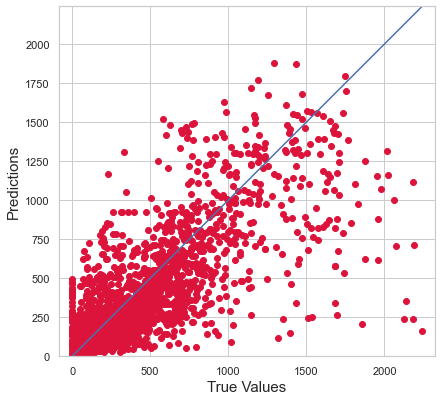

In [156]:
true_value = df_y_test
predicted_value = pd.DataFrame(base_model1.predict(X_test),columns =["predicted"], index = df_y_test.index )
plt.figure(figsize=(6,6))
plt.scatter(true_value, predicted_value, c='crimson')


p1 = max(max(predicted_value.iloc[:,0]), max(true_value.iloc[:,0]))
# p2 = min(min(predicted_value.iloc[:,0]), min(true_value.iloc[:,0]))
plt.plot([p1, 0], [p1, 0], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
sns.set_theme(style = "whitegrid")
plt.axis('equal')
plt.xlim([0, p1])
plt.ylim([0, p1])

plt.show();

#### so we can see that we have much better results, let's add some new columns

In [157]:
col = ['Year', 'Month', 'Day', 'Time', 'Temp (°C)',
       'Rel Hum (%)', 'Wind Spd (km/h)', 'numeric_weather', 'weekend']

X_train = select_columns(df_X_train, col)
X_test = select_columns(df_X_test, col)

base_model2 = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model2.fit(X_train, df_y_train)
base_r2 = r2_score(df_y_test , base_model2.predict(X_test) )
base_r2

0.7067389538712237

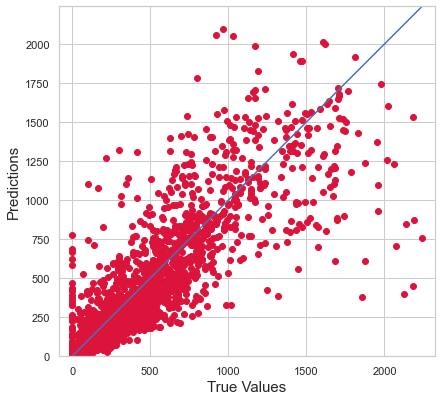

In [158]:
true_value = df_y_test
predicted_value = pd.DataFrame(base_model2.predict(X_test),columns =["predicted"], index = df_y_test.index )
plt.figure(figsize=(6,6))
plt.scatter(true_value, predicted_value, c='crimson')


p1 = max(max(predicted_value.iloc[:,0]), max(true_value.iloc[:,0]))
# p2 = min(min(predicted_value.iloc[:,0]), min(true_value.iloc[:,0]))
plt.plot([p1, 0], [p1, 0], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
sns.set_theme(style = "whitegrid")
plt.axis('equal')
plt.xlim([0, p1])
plt.ylim([0, p1])

plt.show();

#### much better

In [159]:
col = ['Year', 'Month', 'Day', 'Time', 'Temp (°C)',
       'Rel Hum (%)', 'Wind Spd (km/h)', 'numeric_weather', 'weekend',
       'type_Clear', 'type_Moist', 'type_Rain', 'type_Snow']

X_train = select_columns(df_X_train, col)
X_test = select_columns(df_X_test, col)

base_model3 = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model3.fit(X_train, df_y_train)
base_r2 = r2_score(df_y_test , base_model3.predict(X_test) )
base_r2

0.6984314644021096

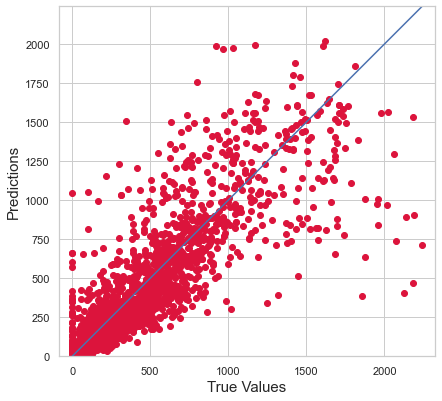

In [160]:
true_value = df_y_test
predicted_value = pd.DataFrame(base_model3.predict(X_test),columns =["predicted"], index = df_y_test.index )
plt.figure(figsize=(6,6))
plt.scatter(true_value, predicted_value, c='crimson')


p1 = max(max(predicted_value.iloc[:,0]), max(true_value.iloc[:,0]))
# p2 = min(min(predicted_value.iloc[:,0]), min(true_value.iloc[:,0]))
plt.plot([p1, 0], [p1, 0], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
sns.set_theme(style = "whitegrid")
plt.axis('equal')
plt.xlim([0, p1])
plt.ylim([0, p1])

plt.show();

#### Now we can use our pca and check its results


In [52]:
base_model4 = RandomForestRegressor(n_estimators = 10, random_state = 42)
for i in range(4, pca_X_train.shape[1]):
    base_model4.fit(pca_X_train.iloc[:, 0:i+1], df_y_train)
    y_prd = base_model4.predict(pca_X_test.iloc[:, 0:i+1])
    base_r2 = r2_score(df_y_test , base_model4.predict(pca_X_test.iloc[:, 0:i+1]))
    print("the number of pca: {}".format(i+1) + " rmse is {0:.2f}".format(base_r2))


the number of pca: 5 rmse is 0.38
the number of pca: 6 rmse is 0.36
the number of pca: 7 rmse is 0.54
the number of pca: 8 rmse is 0.54
the number of pca: 9 rmse is 0.56
the number of pca: 10 rmse is 0.57
the number of pca: 11 rmse is 0.58
the number of pca: 12 rmse is 0.57
the number of pca: 13 rmse is 0.57


#### we can see that pca is not adding to r2 

### let's optimize the Random Forest Regressor

In [54]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
model_rf  = RandomForestRegressor()

rf_random = RandomizedSearchCV(
    estimator = model_rf,
    param_distributions = random_grid,
    n_iter = 100,
    cv = 5,
    verbose=2,
    random_state=42,
    n_jobs = -1)

rf_random.fit(X_train, df_y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [55]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': True}

In [56]:
best_random = rf_random.best_estimator_
random_accuracy = r2_score(df_y_test , best_random.predict(X_test))
random_accuracy

0.7460866243791467

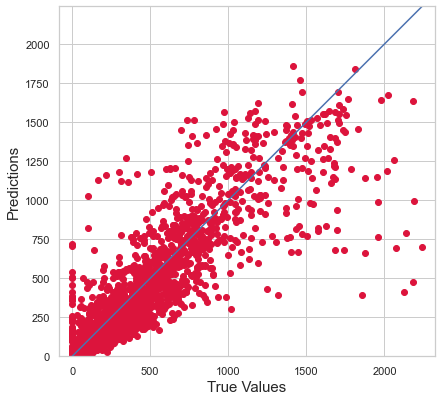

In [161]:
true_value = df_y_test
predicted_value = pd.DataFrame(best_random.predict(X_test),columns =["predicted"], index = df_y_test.index )
plt.figure(figsize=(6,6))
plt.scatter(true_value, predicted_value, c='crimson')


p1 = max(max(predicted_value.iloc[:,0]), max(true_value.iloc[:,0]))
# p2 = min(min(predicted_value.iloc[:,0]), min(true_value.iloc[:,0]))
plt.plot([p1, 0], [p1, 0], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
sns.set_theme(style = "whitegrid")
plt.axis('equal')
plt.xlim([0, p1])
plt.ylim([0, p1])

plt.show();

### predicting 1 day

In [61]:
best_random = rf_random.best_estimator_
random_accuracy = r2_score(df_y_test.iloc[:24,] , best_random.predict(X_test.iloc[:24,]))
random_accuracy

0.9469965045361501

In [163]:
best_random.predict(X_test.iloc[:24,])

array([ 861.64260395, 1126.10620987, 1544.8653081 , 1438.06184017,
       1376.36884861, 1006.9316805 ,  712.23602323,  461.73405   ,
        324.2942846 ,  152.94495774,   85.72405711,   56.09299742,
         28.99986488,   28.12069441,   76.78554951,  277.08484563,
        541.48846647,  751.81927599,  558.03519821,  491.86411389,
        576.86628295,  738.54662381,  734.09415817,  773.5765125 ])

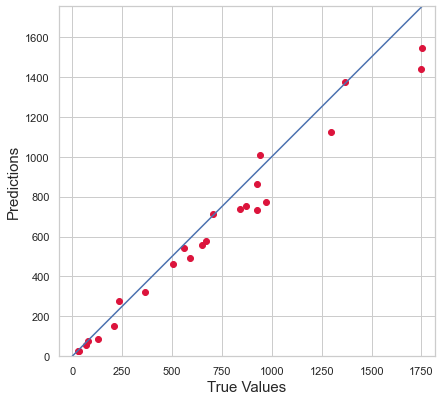

In [164]:
true_value = df_y_test.iloc[:24,]
predicted_value = pd.DataFrame(best_random.predict(X_test.iloc[:24,]),columns =["predicted"],
                               index = df_y_test.iloc[:24,].index )
plt.figure(figsize=(6,6))
plt.scatter(true_value, predicted_value, c='crimson')


p1 = max(max(predicted_value.iloc[:,0]), max(true_value.iloc[:,0]))
# p2 = min(min(predicted_value.iloc[:,0]), min(true_value.iloc[:,0]))
plt.plot([p1, 0], [p1, 0], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
sns.set_theme(style = "whitegrid")
plt.axis('equal')
plt.xlim([0, p1])
plt.ylim([0, p1])

plt.show();

### predicting 1 week

In [63]:
best_random = rf_random.best_estimator_
random_accuracy = r2_score(df_y_test.iloc[:168,] , best_random.predict(X_test.iloc[:168,]))
random_accuracy

0.9203582643078152

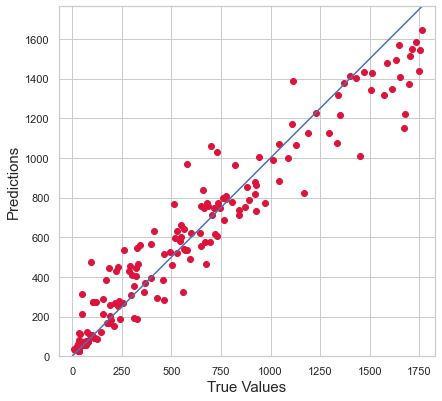

In [165]:
true_value = df_y_test.iloc[:168,]
predicted_value = pd.DataFrame(best_random.predict(X_test.iloc[:168,]),columns =["predicted"],
                               index = df_y_test.iloc[:168,].index )
plt.figure(figsize=(6,6))
plt.scatter(true_value, predicted_value, c='crimson')


p1 = max(max(predicted_value.iloc[:,0]), max(true_value.iloc[:,0]))
# p2 = min(min(predicted_value.iloc[:,0]), min(true_value.iloc[:,0]))
plt.plot([p1, 0], [p1, 0], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
sns.set_theme(style = "whitegrid")
plt.axis('equal')
plt.xlim([0, p1])
plt.ylim([0, p1])

plt.show();

### predicting 1 month

In [65]:
best_random = rf_random.best_estimator_
random_accuracy = r2_score(df_y_test.iloc[:720,] , best_random.predict(X_test.iloc[:720,]))
random_accuracy

0.7642434896767836

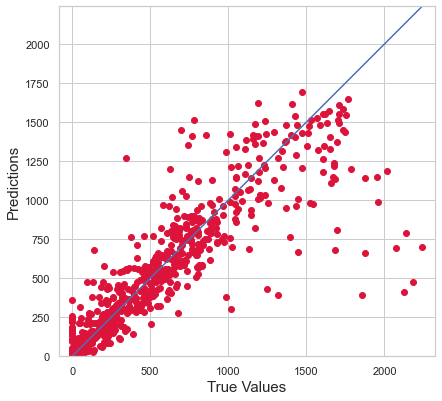

In [166]:
true_value = df_y_test.iloc[:720,]
predicted_value = pd.DataFrame(best_random.predict(X_test.iloc[:720,]),columns =["predicted"],
                               index = df_y_test.iloc[:720,].index )
plt.figure(figsize=(6,6))
plt.scatter(true_value, predicted_value, c='crimson')


p1 = max(max(predicted_value.iloc[:,0]), max(true_value.iloc[:,0]))
# p2 = min(min(predicted_value.iloc[:,0]), min(true_value.iloc[:,0]))
plt.plot([p1, 0], [p1, 0], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
sns.set_theme(style = "whitegrid")
plt.axis('equal')
plt.xlim([0, p1])
plt.ylim([0, p1])

plt.show();

### predicting 3 months

In [67]:
best_random = rf_random.best_estimator_
random_accuracy = r2_score(df_y_test , best_random.predict(X_test))
random_accuracy

0.7460866243791467

# Graph

In [86]:
lst_r2, lst_days = [], []
for i in range(13):
    temp_index = 24 * (i*7 + 1)
    lst_days.append(i * 7 +1)
    if i == 0:    
        lst_r2.append(r2_score(df_y_test.iloc[:temp_index,] , best_random.predict(X_test.iloc[:temp_index,])))
    else:
        lst_r2.append(r2_score(
            df_y_test.iloc[(temp_index -24):temp_index,], best_random.predict(X_test.iloc[(temp_index -24):temp_index,])))
